# Network eCREST



# Setup

Do the following two setup steps regardless of how you will be using this script. 

## 1. Imports

Run the following code cell to import the necessary packages and modules. 

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
import random
from random import choice as random_choice
from itertools import combinations
import itertools
from numpy import array, unravel_index, argmin, mean,unique
import matplotlib
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import datetime
from time import time, sleep
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import matplotlib.pyplot as plt
import seaborn as sns

from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [2]:
vx_sizes = [16, 16, 30]

def get_viewer(backgnd_color = "black"):
    viewer = neuroglancer.Viewer()
    viewer.set_state({})

    location=[17000,17000,1500]

    with viewer.config_state.txn() as s:
        s.show_layer_panel = True ###

    with viewer.txn(overwrite=True) as s:

        dimensions = neuroglancer.CoordinateSpace(
            scales=vx_sizes,# self.vx_sizes['em'],
            units='nm',
            names=['x', 'y', 'z']   )

        s.showSlices = False
        s.dimensions = dimensions
        s.position = array(location)
        s.layout = "3d"
        s.projectionScale = 30000
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]#"#000000"
        # s.projection_background_color= "#ffffff"
        s.showSlices = False

    with viewer.txn(overwrite=True) as s:
        wb_open(str(viewer))
    
    return viewer

def create_baseseg_layer(viewer, source, lname, visible = False, objectAlpha = 1):
    with viewer.txn(overwrite=True) as s:
        s.layers[lname] = neuroglancer.SegmentationLayer(source = source, segments=[], segment_colors={})
        s.layers[lname].ignoreNullVisibleSet = False
        s.layers[lname].pick = True
        s.layers[lname].selectedAlpha = 0.5 #For 2D
        s.layers[lname].objectAlpha = objectAlpha
        s.layers[lname].visible = visible
                 

def create_em_layer(viewer, source = 'brainmaps://10393113184:ell:roi450um_xyz'):
    with viewer.txn(overwrite=True) as s:
        s.layers['em'] = neuroglancer.ImageLayer(source = source)

def clear_baseseg_layer(viewer, lname):
    displayed_segs = set([str(x) for x in viewer.state.layers[lname].segments])

    # REMOVE SEGMENTS FROM NGviewer
    remove_segs = displayed_segs

    with viewer.txn(overwrite=True) as s:
        for bs in remove_segs:
            if int(bs) in s.layers[lname].segments:
                s.layers[lname].segments.remove(int(bs))

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


## 2. Settings and files

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

db_cursors = sqlite3_connect(settings_dict['db_path'], check_same_thread=False).cursor()

a = ', '.join(['base_address'])

db_cursors.execute(f'''SELECT {a} FROM addresses_table LIMIT 1''')

[base_seg] = db_cursors.fetchall()[0]


In [4]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

# em viewer

In [4]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)

In [5]:
create_baseseg_layer(viewer, base_seg, 'base_segs')

In [6]:
point_type = 'reconstruct'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#888888'

# Vizualize sensory versus negative image input

In [6]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodefiles = get_cell_filepaths(dirpath)
                    

## Load graph dataframes 

In [75]:
savepath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/graphs/')

df_syn_pre = pd.read_csv(savepath / 'df_presyn.csv')
df_syn_post = pd.read_csv(savepath / 'df_postsyn.csv')

# df_syn_post.loc[df_syn_post['pre']==285761792,'pre_type']='pe'

In [7]:
# network_types = ['mg1','mg2','lg','lf','sg1','sg2','grc','aff']

# df_syn_post = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(network_types))]
# df_syn_pre = df_syn_pre[(df_syn_pre['pre_type'].isin(network_types))&(df_syn_pre['post_type'].isin(network_types))]

In [78]:
focal_cell_id = 301787806 # lg # 285761792 # 299496636 #mg1  # 214581797 # mg2 # 386392158 # partial mg2 # 393325331 # lf #   299392199 # partial mg1 #  61319896 # grc-s # 385234105 # dml #  128832297 # sg1 # 50786130 # sg2 # 392042360 # grc-s #   392042360 # grc-s #218095913 #sg2 # 

In [29]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id]['post_type'].unique()

array(['uk', 'sg2', 'grc-d', 'sgx2', 'fov', 'mg2', 'lg'], dtype=object)

In [63]:
df_syn_post[df_syn_post['pre']==focal_cell_id]['post_type'].unique()

array(['uk', 'lf', 'grc-d', 'sg2', 'mg2', 'fov', 'sgx2', 'grc-s'],
      dtype=object)

## load focal cell

In [30]:
dirpath = Path(settings_dict['save_dir'])
focal_cell_fname = nodefiles[str(focal_cell_id)]#'cell_graph_214581797__2023-07-17 12.58.20.json'

cell = ecrest(settings_dict,filepath = dirpath / focal_cell_fname, launch_viewer=False)

## create viewer

In [71]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)

In [33]:
lname = 'focal_cell_' + str(focal_cell_id)
create_baseseg_layer(viewer, base_seg, lname, objectAlpha=1)


# structure_colors = {'unknown': '#4d4d4d',
#                     'multiple': '#4d4d4d',
#                     'axon': '#b3b3b3',
#                     'basal dendrite': '#4d4d4d',
#                     'apical dendrite': '#4d4d4d'
#                    } 

structure_colors = {'unknown': '#d2b48c',
                    'multiple': '#9c661f',
                    'axon': '#008000',
                    'basal dendrite': '#cd4b00',
                    'apical dendrite': '#ff8000'
                   } 

with viewer.txn(overwrite=True) as s:
    for dtype in cell.cell_data['base_segments'].keys():
        for bs in cell.cell_data['base_segments'][dtype]:
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = structure_colors[dtype] #'#ffffff'# blue

In [194]:
point_type = 'pre-synaptic'
p_name = 'all_pre'

with viewer.txn(overwrite=True) as s:
    s.layers[p_name] = neuroglancer.AnnotationLayer()
    s.layers[p_name].annotationColor = '#ffffff'
    

    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[p_name].annotations.append(pa)    

In [191]:
point_type = 'pre-synaptic'
print(f'{len(cell.cell_data["end_points"][point_type])} total input synapses')
print(f'{len(df_syn_pre[df_syn_pre["pre"]==focal_cell_id])} input synapses that are reconstructed within network_types cell types')

206 total input synapses
188 input synapses that are reconstructed within network_types cell types


In [192]:
df = df_syn_pre[df_syn_pre['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(name='weight').rename(columns={'post_type': 'pre_type'})

df.groupby('pre_type').agg({'pre_type': 'count', 'weight': 'sum'}).rename(columns={'pre_type': 'count'}).reset_index()

,pre_type,count,weight
0,aff,2,7
1,dml,6,15
2,fov,1,2
3,grc-s,10,42
4,mg1,1,1
5,sg1,20,42
6,sgx1,11,27
7,sgx2,1,1
8,uk,40,51


In [112]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(name='weight').head()

# display(df_syn_pre[df_syn_pre['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(
#     name='weight')['post_type'].value_counts().reset_index(name='ncells'))

,post,post_type,weight
0,306242528,grc-s,10
1,389812730,grc-s,8
2,131029691,grc-s,7
3,392102325,sgx1,6
4,301682826,sgx2,6


In [127]:
df_syn_pre[(df_syn_pre['pre']==focal_cell_id) & (df_syn_pre['post_type'].isin(['sgx2']))]

In [83]:
point_type = 'post-synaptic'
p_name = 'all_post'

with viewer.txn(overwrite=True) as s:
    s.layers[p_name] = neuroglancer.AnnotationLayer()
    s.layers[p_name].annotationColor = '#ffffff'
    

    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[p_name].annotations.append(pa)    

In [26]:
point_type = 'post-synaptic'
print(f'{len(cell.cell_data["end_points"][point_type])} total output synapses')
print(f'{len(df_syn_post[df_syn_post["pre"]==focal_cell_id])} output synapses that are reconstructed within network_types cell types')

131 total output synapses
90 output synapses that are reconstructed within network_types cell types


In [27]:
df = df_syn_post[df_syn_post['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(name='weight')

df.groupby('post_type').agg({'post_type': 'count', 'weight': 'sum'}).rename(columns={'post_type': 'count'}).reset_index()

,post_type,count,weight
0,dml,4,7
1,fov,1,1
2,lf,4,5
3,lg,2,2
4,mg1,5,5
5,mg2,12,20
6,sg1,3,4
7,sg2,12,29
8,tsd,3,9
9,uk,4,8


In [116]:
df_syn_post[df_syn_post['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(name='weight').head()


,post,post_type,weight
0,300474334,lg,17
1,128770984,lg,15
2,301727988,lg,10
3,42968640,fov,8
4,47378810,fov,6


## synapse annotation colors

In [17]:
syn_colors = {
    'sgx1':'#996633',
    'sgx2':'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff'
}

## presynaptic

In [44]:
df_syn_pre[df_syn_pre['pre']==focal_cell_id]['post_type'].dropna().unique()

array(['fov', 'mg1', 'sg1', 'uk', 'aff', 'grc-s', 'sgx1'], dtype=object)

In [193]:

for p in df_syn_pre[df_syn_pre['pre']==focal_cell_id]['post_type'].dropna().unique():
    with viewer.txn(overwrite=True) as s:
        s.layers[p + '_pre'] = neuroglancer.AnnotationLayer()
        try:
            s.layers[p + '_pre'].annotationColor = syn_colors[p]
        except:
            s.layers[p + '_pre'].annotationColor = '#000000'

# with viewer.txn(overwrite=True) as s:
        for pos, point in df_syn_pre[(df_syn_pre['pre']==focal_cell_id) & (df_syn_pre['post_type']==p)].dropna().iterrows():
            point_array = array([point[x]/vx_sizes[i] for i,x in zip(range(3),['x','y','z'])])# array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
            point_id = f'{p}_{pos}'
            # print(point_array)

            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[p + '_pre'].annotations.append(pa)   
    sleep(1)

In [35]:
lname = 'reciprocal_pre'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#ff0000'
    
    for pos, point in df_syn_pre[df_syn_pre['pre']==focal_cell_id].dropna().iterrows():
        if point['post'] in df_syn_post[df_syn_post['pre']==focal_cell_id]['post'].dropna().unique():
            point_array = array([point[x] for x in ['x','y','z']]) #array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
            point_id = f'{point["post_type"]}_{pos}'
            # print(point_array)

            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname].annotations.append(pa)    

Make a base segment layer for all segments not reconstructed yet (as long as all file sizes are small)

In [22]:
lname = 'todo'
create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)

dirpath = Path(settings_dict['save_dir']) / 'todo_presynaptic/lf_393325331'# mg1_299496636' #mg2_214581797' #

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

In [23]:
len(nodefiles)

212

In [24]:
todo_segs = []

for f in nodefiles.values():
    todo_cell = ecrest(settings_dict,filepath = f, launch_viewer=False)
    todo_segs.extend([a for b in todo_cell.cell_data['base_segments'].values() for a in b])
    
with viewer.txn(overwrite=True) as s:
    # for dtype in todo_cell.cell_data['base_segments'].keys():
    for bs in todo_segs:#[a for b in todo_cell.cell_data['base_segments'].values() for a in b]: #todo_cell.cell_data['base_segments'][dtype]:
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ff0000' #structure_colors[dtype] # blue

In [25]:
len(todo_segs)

344

## postsynaptic

In [19]:
df_syn_post[df_syn_post['pre']==focal_cell_id]['post_type'].unique()

array(['mg2', 'sg2', 'lf', 'mg1', 'uk', 'sg1', 'dml', 'tsd', 'lg', 'fov'],
      dtype=object)

In [ ]:

for p in df_syn_post[df_syn_post['pre']==focal_cell_id]['post_type'].dropna().unique():
    with viewer.txn(overwrite=True) as s:
        s.layers[p + '_post'] = neuroglancer.AnnotationLayer()
        try:
            s.layers[p + '_post'].annotationColor = syn_colors[p]
        except:
            s.layers[p + '_post'].annotationColor = '#000000'

# point_type = 'post-synaptic'
with viewer.txn(overwrite=True) as s:
    for pos, point in df_syn_post[df_syn_post['pre']==focal_cell_id].iterrows():
        
        point_array = array([point[x]/vx_sizes[i] for i,x in zip(range(3),['x','y','z'])])  #array([point[x] for x in ['x','y','z']]) #
        point_id = f'{point["post_type"]}_{pos}'

        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point["post_type"] + '_post'].annotations.append(pa)    
        # print(pa)

In [586]:
lname = 'reciprocal_post'
with viewer.txn(overwrite=True) as s:
    s.layers[lname] = neuroglancer.AnnotationLayer()
    s.layers[lname].annotationColor = '#ff0000'
    
    for pos, point in df_syn_post[df_syn_post['pre']==focal_cell_id].iterrows():
        if point['post'] in df_syn_pre[df_syn_pre['pre']==focal_cell_id]['post'].unique():
            point_array = array([point[x] for x in ['x','y','z']]) #array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
            point_id = f'{point["post_type"]}_{pos}'
            # print(point_array)

            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname].annotations.append(pa)    
            
        if point['post'] in df_syn_post[df_syn_post['post']==focal_cell_id]['pre'].unique():
            point_array = array([point[x] for x in ['x','y','z']]) #array([int(point[x]/vx_sizes[i]) for i,x in enumerate(['x','y','z'])])
            point_id = f'{point["post_type"]}_{pos}'
            # print(point_array)

            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname].annotations.append(pa)    

## Find segment in network

In [7]:
nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [8]:
crest = ecrest(settings_dict,launch_viewer=False)
base_segments = crest.get_base_segments_dict(Path(dirpath))

In [9]:
segid_to_find = '283438175'
[k for k,v in base_segments.items() if segid_to_find in v]

[]

In [36]:
c_id = '136801845'
cell = ecrest(settings_dict,filepath = dirpath / nodefiles[c_id], launch_viewer=True)

updating viewer status message: Current Base Segment Counts: unknown: 248, axon: 28, basal dendrite: 58, apical dendrite: 13, dendrite: 0, multiple: 0


In [37]:
cell.cell_data['metadata']

{'main_seg': {'agglo': {'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930:v230111c_16_strict_only_spl': '220385169'},
  'base': '136801845'},
 'data_sources': {'em': 'brainmaps://10393113184:ell:roi450um_xyz',
  'base': 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930',
  'agglo': 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930:v230111c_16_strict_only_spl'},
 'timing': [1.6637643178304036e-05, 4.5664907693862915, 0.6177784522374471],
 'completion': [],
 'cell-type': {'manual': 'grc-d', 'auto': []},
 'old-anchor': ['221514452', '136801534']}

In [28]:
cell.add_endpoint_annotation_layers(['soma'])

In [38]:
cell.get_ctype('manual')

'grc-d'

In [39]:
cell.save_cell_graph()

Saved cell 136801845 reconstruction locally at 2023-09-25 20.30.01


## Add other cells to visualization


In [47]:
# cells_to_add =['558238428','558189118','128708970','214627855','213699579','386470356']
# cells_to_add = ['127672247','386409916','386488569','473336431','388914881','47194079']
# cells_to_add =  ['214581797','299496636','301787806','393325331']
# cells_to_add =  ['216977942', '219161561', '305020954', '305051491', '306242528',
#        '389812730', '392042360', '45120720', '565013265']
# cells_to_add = ['310839225',
#  '397827768',
#  '568543816',
#  '568525178',
#  '567365263',
#  '481507678',
#  '481505952',
#  '396744989',
#  '567364173',
#  '481489597']
# cells_to_add = ['301787806','393325331'] # lg and lf example pre cells
cells_to_add = ['299496636','214581797'] #mg1 and mg2 example pre cells

In [76]:
p = ['pe','pf']
df = df_syn_post
cells_to_add = df[df['pre_type'].isin(p)]['pre'].unique() #df[(df['pre']==focal_cell_id) & (df['post_type'].isin(p))]['post'].unique()
cells_to_add = [str(c) for c in cells_to_add]
print(len(cells_to_add))
cells_to_add#[0:20]

13


['183918283',
 '285761792',
 '290291065',
 '297177312',
 '372899977',
 '441321646',
 '463077884',
 '530044972',
 '630355985',
 '634858913',
 '636004167',
 '638373058',
 '642782594']

In [65]:
cells_to_add = ['299404889']

In [66]:
color_structure = {'axon':'#008000','basal dendrite':'#cd4b00','apical dendrite':'#ff8000','unknown':'#d2b48c','multiple':'#9c661f','dendrite':'#ffff00'}
segs_to_add = {}
cell_types = {}
for c_id in cells_to_add: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[c_id], launch_viewer=False)
    segs_to_add[c_id] = cell.cell_data['base_segments'] #[a for b in cell.cell_data['base_segments'].values() for a in b]
    cell_types[c_id]=cell.get_ctype('manual')

# each cell to a different tab    
for c_id in segs_to_add:
    lname = c_id + '_' + cell_types[c_id]#cell.get_ctype('manual')
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    with viewer.txn(overwrite=True) as s:
        for dtype,keys in segs_to_add[c_id].items(): #segs_to_add[c_id]:
            if dtype == 'apical dendrite':
                for bs in keys: 
                    s.layers[lname].segments.add(int(bs))
                    s.layers[lname].segment_colors[int(bs)] = syn_colors[cell_types[c_id]]#color_structure[dtype]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

In [77]:
color_structure = {'axon':'#008000','basal dendrite':'#cd4b00','apical dendrite':'#ff8000','unknown':'#d2b48c','multiple':'#9c661f','dendrite':'#ffff00'}
segs_to_add = {}
cell_types = {}
for c_id in cells_to_add: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[c_id], launch_viewer=False)
    segs_to_add[c_id] = cell.cell_data['base_segments'] #[a for b in cell.cell_data['base_segments'].values() for a in b]
    cell_types[c_id]=cell.get_ctype('manual')

# each cell to a different tab    
for c_id in segs_to_add:
    lname = c_id + '_' + cell_types[c_id]
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    with viewer.txn(overwrite=True) as s:
        for dtype,keys in segs_to_add[c_id].items(): #segs_to_add[c_id]:
            # if dtype in ['apical dendrite']:
            for bs in keys: 
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = '#000000' #color_structure[dtype]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

In [44]:
# all cells to same tab
lname = 'cells added'
create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)#0.5)
for c_id in segs_to_add:
    # lname = c_id #+ '_' + cell.get_ctype('manual')
    # create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)#0.5)
    with viewer.txn(overwrite=True) as s:
        for dtype,keys in segs_to_add[c_id].items(): #segs_to_add[c_id]:
            for bs in keys: 
                    s.layers[lname].segments.add(int(bs))
                    s.layers[lname].segment_colors[int(bs)] = '#000000' #color_structure[dtype]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

### cell type change

In [ ]:
[, '', '', '', '', '']

In [217]:
c_id = '485096532'
cell_type = 'lf'

filepath = nodefiles[c_id]
crest = ecrest(settings_dict,filepath= filepath, launch_viewer=False)

method = 'manual' # define which method you are using (manual or auto)
crest.define_ctype(cell_type,method)

crest.save_cell_graph(directory_path = Path(settings_dict['save_dir']), file_name = nodefiles[c_id])

Saved cell 485096532 reconstruction locally at 2023-09-01 09.58.50


# Visualize Soma locations by annotation

In [30]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


In [31]:
soma_diam = {}
soma_loc = {}
cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    
    
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        xpts = [p[0] for p in soma_anno]
        ypts = [p[1] for p in soma_anno]
        zpts = [p[2] for p in soma_anno]

        soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))/16),int((np.max(zpts)-np.min(zpts))/16)])/100
        
        soma_loc[x] = [np.mean(xpts)/16,np.mean(ypts)/16,np.mean(zpts)/30]
        
        cell_type[x] = cell.get_ctype('manual') 

In [134]:
df_loc = pd.DataFrame(soma_loc).T
df_loc.columns=['x','y','z']

dict_list = [soma_diam, cell_type]

dfs = [pd.DataFrame(d.values()) for d in dict_list]

df_ = pd.concat(dfs, axis=1)

df_.columns = ['soma_diam','cell_type']
df_.index = soma_diam.keys()

df_soma = pd.concat([df_,df_loc],axis=1)

In [104]:
df_soma

,soma_diam,cell_type,x,y,z
126618353,6.730,mg1,19513.727539,15712.367920,701.868210
126649726,8.805,mg2,20084.000000,15854.750000,851.000000
127641472,4.185,sg1,15585.595703,16044.378418,745.750000
128536704,7.870,mg2,8823.914551,16410.256104,850.407700
128676205,5.025,sg1,12744.151611,16628.427734,762.825912
...,...,...,...,...,...
643832186,7.250,sg2,10185.500000,16420.250000,3311.750000
644143297,6.155,mg1,18877.044922,16643.702148,3405.685852
644205547,6.230,mg2,20434.858887,16653.431152,3387.518738
644853727,5.910,sg1,6618.575439,17172.023926,3317.648315


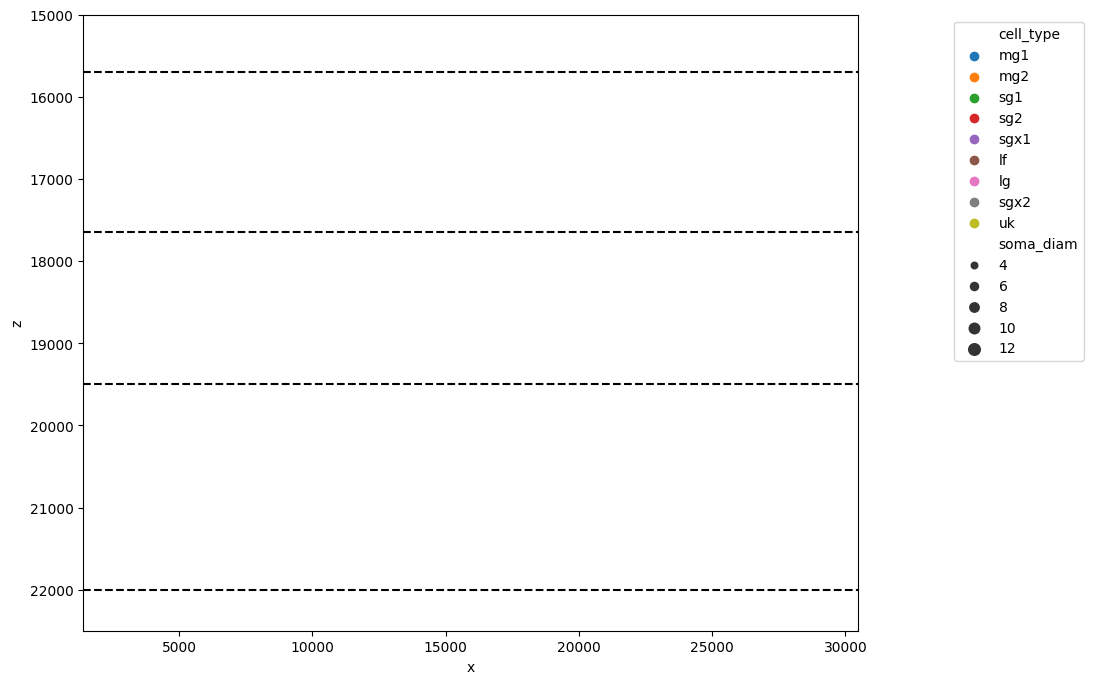

In [41]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.scatterplot(data=df_soma,x='x',y='y',hue='cell_type',size='soma_diam',alpha = 0.75)
for y_ in [22000, 19500, 17650, 15700]:
    ax.axhline(y=y_,color = 'black',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylim(15000,22500)
ax.invert_yaxis()


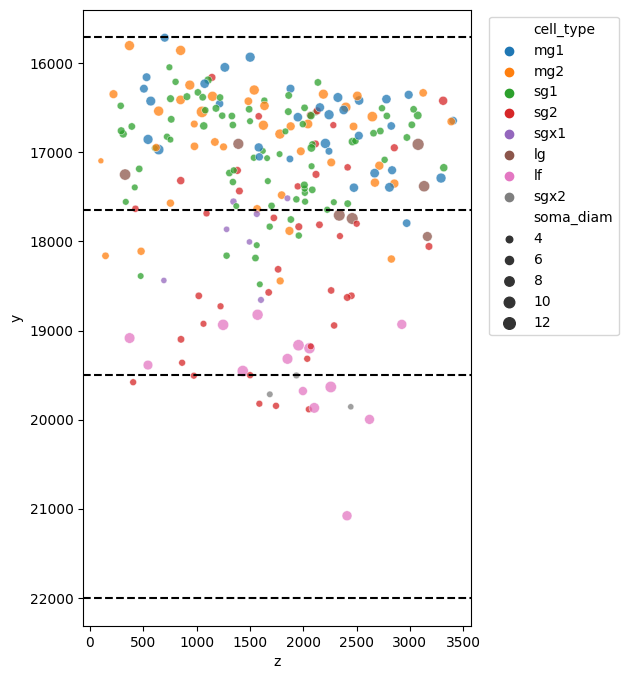

In [117]:
hfig,ax = plt.subplots(1,figsize=(5,8))
sns.scatterplot(data=df_soma,x='z',y='y',hue='cell_type',size='soma_diam',alpha = 0.75)
for y_ in [22000, 19500, 17650, 15700]:
    ax.axhline(y=y_,color = 'black',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.4, 1))
ax.invert_yaxis()

# vizualize all post-synaptic annotations

## color by whether the segment is part of a current reconstrution or not

In [79]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"


nodefiles = get_cell_filepaths(dirpath)
                    
all_base_seg = []
for x in nodefiles.keys():
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    all_base_seg.extend([a for b in cell.cell_data['base_segments'].values() for a in b])

KeyboardInterrupt: 

In [144]:
all_syn = []

for x_pre in nodefiles.keys():
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is an mg cell and if it has post-synaptic segments labeled
    if (pre.get_ctype('manual') in ['mg1','mg2']) & (pre.cell_data['end_points']['post-synaptic'] != []):
        try:
            all_syn.extend(pre.cell_data['end_points']['post-synaptic'])
            
        except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')

df = pd.DataFrame(all_syn, columns = ['x','y','z','segid'])

syn_missing = set(set(df['segid'].values)).difference(set(all_base_seg))

syn_found = set(df['segid'].values).difference(syn_missing)

In [146]:
viewer = get_viewer(backgnd_color="white")
create_baseseg_layer(viewer, base_seg, 'volume')

In [148]:


point_type = 'reconstructed'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ff0000'
    
    for pos,r in df[df['segid'].isin(list(syn_found))][['x','y','z']].iterrows():
        point = [r[0],r[1],r[2]]
    # for pos, point in enumerate(self.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)    

point_type = 'missing'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#228b22'

    for pos,r in df[df['segid'].isin(list(syn_missing))][['x','y','z']].iterrows():
        point = [r[0],r[1],r[2]]
    # for pos, point in enumerate(self.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)    


## annotation layers of synapses by cell type

In [80]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodefiles = get_cell_filepaths(dirpath)

cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

cell 125487414 is not cell-typed in json
cell 130919950 is not cell-typed in json
cell 302935179 is not cell-typed in json


In [81]:
syn_colors = {
    'sgx1':'#00ffff', #'#996633',
    'sgx2':'#ff9900', #'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff'
}

In [82]:
viewer = get_viewer(backgnd_color="white")
# create_baseseg_layer(viewer, base_seg, 'volume')
create_em_layer(viewer)

In [83]:

point_type = ['grc-s']

for lname_ in point_type:
    all_syn = []
    for x,f in nodefiles.items():
        if cell_type[x] in [lname_]:
            cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
            all_syn.extend(cell.cell_data['end_points']['post-synaptic'])

    with viewer.txn(overwrite=True) as s:
        s.layers[lname_] = neuroglancer.AnnotationLayer()
        s.layers[lname_].annotationColor = syn_colors[lname_]#'#000000'# '#7300e6' # purple

        for pos, point in enumerate(all_syn):
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{lname_}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname_].annotations.append(pa)   

## soma locations

In [28]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodefiles = get_cell_filepaths(dirpath)


In [29]:
soma_diam = {}
soma_loc = {}
cell_type = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    
    
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        xpts = [p[0] for p in soma_anno]
        ypts = [p[1] for p in soma_anno]
        zpts = [p[2] for p in soma_anno]

        soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))/16),int((np.max(zpts)-np.min(zpts))/16)])/100
        
        soma_loc[x] = [np.mean(xpts)/16,np.mean(ypts)/16,np.mean(zpts)/30]
        
        cell_type[x] = cell.get_ctype('manual') 

In [30]:
df_loc = pd.DataFrame(soma_loc).T
df_loc.columns=['x','y','z']

dict_list = [soma_diam, cell_type]

dfs = [pd.DataFrame(d.values()) for d in dict_list]

df_ = pd.concat(dfs, axis=1)

df_.columns = ['soma_diam','cell_type']
df_.index = soma_diam.keys()

df_soma = pd.concat([df_,df_loc],axis=1)

In [49]:
df_soma

,soma_diam,cell_type,x,y,z
126618353,6.730,mg1,19513.727539,15712.367920,701.868210
126649726,8.805,mg2,20084.000000,15854.750000,851.000000
127607174,6.290,mg2,14666.599854,16033.227051,557.405136
127641472,4.185,sg1,15585.595703,16044.378418,745.750000
127672247,6.150,sg2,16382.405029,15899.806641,859.074707
...,...,...,...,...,...
644205547,6.230,mg2,20434.858887,16653.431152,3387.518738
644853727,5.910,sg1,6618.575439,17172.023926,3317.648315
646633319,8.685,mg1,23965.501465,17287.995117,3292.038696
647421579,3.560,sgx1,14540.198486,17841.958496,3132.432434


In [32]:
point_type = ['mg2','mg1','sg2','sg1']#,'sgx1','sgx2','grc-s','grc-d','aff','lf','lg']
for lname_ in point_type:
    all_soma = []
    for i,r in df_soma.iterrows():
        if r['cell_type'] in [lname_]:
            
            all_soma.append(r[['x','y','z']])

    with viewer.txn(overwrite=True) as s:
        s.layers[lname_] = neuroglancer.AnnotationLayer()
        s.layers[lname_].annotationColor = syn_colors[lname_]#'#000000'# '#7300e6' # purple

        for pos, point in enumerate(all_soma):
            point_array = point #array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{lname_}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname_].annotations.append(pa)   

# Vizualize locations of segments for each structure and cell type

In [ ]:
results = {}
batch_size=1000
base_segs = all_base_segs[0:10]

if len(base_segs) > 0:

    num_batches = int(len(base_segs)/batch_size)

    for batch in range(num_batches+1):

        q = ','.join([str(x) for x in base_segs[batch*batch_size:(batch+1)*batch_size]])

        # query = f"""SELECT seg_id, x, y, z FROM base_location WHERE seg_id IN ({q})"""
        QUERY = f"""
        SELECT
            cast(objects.id as INT64) as seg_id,
            sample_voxel.x as x,
            sample_voxel.y as y,
            sample_voxel.z as z,
        FROM
            `lcht-goog-connectomics.ell_roi450um_seg32fb16fb_220930.objinfo` as objects
        WHERE objects.id IN ({q})
        """
        main_cell.db_cursors.execute(query)

        this_batch = {str(x[0]): (int(x[1]), int(x[2]), int(x[3])) for x in main_cell.db_cursors.fetchall()}

        results.update(this_batch)


# visualize overlapping segments for duplicates

In [40]:
overlapping_cells = ['387368998','644824967']

In [41]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    
# Create a base_segments dictionary of all cells
base_segments = {}
cell_type={}
for x in [n for n in nodes if n in overlapping_cells]:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']
    cell_type[cell.cell_data['metadata']['main_seg']['base']] = cell.get_ctype('manual')

In [42]:
segs_1 = set([a for b in base_segments[overlapping_cells[0]].values() for a in b])
segs_2 = set([a for b in base_segments[overlapping_cells[1]].values() for a in b])

print(f'{len(segs_1.difference(segs_2))} segments in cell 1 that are not in cell 2')
print(f'{len(segs_2.difference(segs_1))} segments in cell 2 that are not in cell 1')

overlap_seg_list = segs_1 & segs_2
print(f'{len(overlap_seg_list)} segments in both')

6115 segments in cell 1 that are not in cell 2
2390 segments in cell 2 that are not in cell 1
0 segments in both


In [43]:
viewer = get_viewer()
lname = 'base_segs'
create_baseseg_layer(viewer, base_seg, lname)

In [44]:
#vizualize cells
cell_color=['#33cc33','#cc33ff']
for i,n in enumerate(base_segments.keys()):
    with viewer.txn(overwrite=True) as s:
        color_structure = cell_color[i] # blue
        print(n,color_structure)
        for bs in [a for b in base_segments[n].values() for a in b]:
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = color_structure 

# visualize overlapping segemtns
color_structure='#ff0000' #red
with viewer.txn(overwrite=True) as s:
    for bs in list(overlap_seg_list):
        # s.layers[lname].segments.add(int(bs)) # should already be in layer because part of both cells
        s.layers[lname].segment_colors[int(bs)] = color_structure 

387368998 #33cc33
644824967 #cc33ff


# visualize anchor seg by type

requires cell structure labeling to be done because uses "unknown" to identify soma

just plot the anchor segment (so does not require cell structure labeling)

In [280]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [281]:
viewer = get_viewer(backgnd_color="white")

create_em_layer(viewer)

In [282]:

c_type = {'mg2': '#ff0000',
          'mg1': '#0000ff',
          'sg2': '#ff9900',
          'sg1': '#00ccff',
          'grc': '#000000'}


for lname_, col_ in c_type.items():
    create_baseseg_layer(viewer, base_seg, lname_)
    all_seg = []
    for x in nodes:
        if cell_type[x] == lname_:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
            all_seg.append(cell.cell_data['metadata']['main_seg']['base'])

    with viewer.txn(overwrite=True) as s:
        for bs in all_seg:
            s.layers[lname_].segments.add(int(bs))
            s.layers[lname_].segment_colors[int(bs)] = col_#color_structure # blue

If want to use soma (and pick random selection from soma to plot so don't overload it), use the following code cell

In [291]:
viewer = get_viewer(backgnd_color="white")
create_baseseg_layer(viewer, base_seg, 'output')

In [295]:
color_structure = {'lf':'#ff0000','lg':'#0000ff'}

toplot=[]
for x in nodes:
    if cell_type[x] in ['lf','lg']:
        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        try:
            assert len(cell.cell_data['base_segments']['unknown']) < len([a for b in cell.cell_data['base_segments'].values() for a in b])
            # toplot.append(x)
            with viewer.txn(overwrite=True) as s:

                for bs in random.choices(list(cell.cell_data['base_segments']['unknown']),k=50):
                    s.layers['output'].segments.add(int(bs))
                    s.layers['output'].segment_colors[int(bs)] = color_structure[cell_type[x]]
        except: 
            continue
            # print(f'no cell structures labeled for {x} yet')

# cell_color={'lf':'#ff0000','lg':'#0000ff'}
# for out_cell in toplot:
#     with viewer.txn(overwrite=True) as s:
#         color_structure = cell_color[cell_type[out_cell]] # blue

#         for bs in random.choices(list(base_segments[out_cell]['unknown']),k=50):
#             s.layers['base_segs'].segments.add(int(bs))
#             s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue

In [138]:
create_em_layer(viewer)

# visualize cell structure by type

requires cell structure labeling to be done 

In [307]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [353]:
structure_label = 'axon'
base_segments = {'mg1':[]}#{'sg1':[],'sg2':[],'mg1':[],'mg2':[]} #{'mg1':[],'mg2':[]}
# cell_count = {'sgx':0} #{'mg1':0,'mg2':0}
for t in base_segments.keys():
    for x in random.choices([k for k,v in cell_type.items() if v == t],k=15):
        if cell_type[x] == t:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
            if cell.cell_data['base_segments'][structure_label] != set():
                base_segments[t].extend(cell.cell_data['base_segments'][structure_label])
                # cell_count[t] += 1

In [332]:
cell_colors = {
    'mg2' : '#ff0000',
    'mg1' : '#0000ff',
    'lg' : '#ff0000',
    'lf' : '#0000ff',
    'sgx' : '#b3b3b3',
    'sg2' : '#ff9900',
    'sg1' : '#00ccff',
    'grc' : '#000000',
    'aff' : '#b3b3b3',    
}


In [349]:
viewer = get_viewer(backgnd_color="white")

create_em_layer(viewer)

In [354]:
for k,v in base_segments.items():
    create_baseseg_layer(viewer, base_seg, k + '_' + structure_label)
    sleep(3)

    with viewer.txn(overwrite=True) as s:
        for bs in v: #random.choices(list(v),k=int(len(v)*0.5)):
            s.layers[k + '_' + structure_label].segments.add(int(bs))
            s.layers[k + '_' + structure_label].segment_colors[int(bs)] = cell_colors[k] # blue
    sleep(3)

## Add synapse annotations for each cell type

In [345]:

point_type = ['mg2','mg1','sg2','sg1','grc','aff']

for lname_ in point_type:
    all_syn = []
    for x in nodes:
        if cell_type[x] in [lname_]:
            cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
            all_syn.extend(cell.cell_data['end_points']['post-synaptic'])
    sleep(3)
    with viewer.txn(overwrite=True) as s:
        s.layers[lname_] = neuroglancer.AnnotationLayer()
        s.layers[lname_].annotationColor = cell_colors[lname_]
        
        sleep(1)

        for pos, point in enumerate(all_syn):
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{lname_}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[lname_].annotations.append(pa)   

# MG-Output convergence

In [449]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child



In [457]:
# network = {'lf': ['393063300'],#['307591597']
#            'mg1':['128737253','300210608','386224676','474236060'],#low synapse ['214412684','41579854','472175645','643848637'] # high synapse weight
#            'lg':['215526370'],
#            'mg2':['472051969','301308616','129512755','128473437']}#['128473437','215572949','300316308','386117124','472051969','644825148']}

examples = {'mg1': ['127870654'],#,'299530386','41579854']}
            'mg2': ['300689181','299249397']}

color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff', 'lg':'#0000ff', 'lf':'#ff0000',
                  'axon':'#008000','basal dendrite':'#cd4b00','apical dendrite':'#ff8000','unknown':'#d2b48c','multiple':'#9c661f'} #'#ff471a'  #7300e6


In [459]:
viewer = get_viewer(backgnd_color="white")
sleep(1)
for cell_type in ['mg2']:
    for cell_ in examples[cell_type]:
        create_baseseg_layer(viewer, base_seg, cell_)
        sleep(3)
        cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
        sleep(3)
        with viewer.txn(overwrite=True) as s:
            for k,v in cell.cell_data['base_segments'].items():
                for bs in v:
                    s.layers[cell_].segments.add(int(bs))
                    # s.layers[cell_].segment_colors[int(bs)] = color_structure[k] # for cell structures different colors   
                    s.layers[cell_].segment_colors[int(bs)] = color_structure[cell_type] # for uniform cell color
                    if k=='axon':
                        s.layers[cell_].segment_colors[int(bs)] = color_structure[k]#'#808080'
  
        sleep(3)

In [411]:
download_path = Path('/Users/kperks/Downloads')
filepath = download_path / 'mg2.png'

s = viewer.screenshot()
with open(filepath, 'wb') as f:
    f.write(s.screenshot.image)

# MG-MG reciprocal

In [53]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

dirpath = Path(settings_dict['save_dir'])
# for child in sorted(dirpath.iterdir()):
#     if '386392158' in child.name:
#         nodefiles[child.name.split('_')[2]] = child

In [52]:
cells = {
    'sg1': '42676894',
    'sg2': '218095913'}
#     'mg1':'386224676',
#     'mg2':'214581797'
# }
    # 386224676	214581797
    # 42632020	301339154

color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff', 'sg':'#d2b48c','sg1':'#fd9400', 'sg2':'#9934ff'}

In [54]:
viewer = get_viewer(backgnd_color="white")

create_em_layer(viewer)

vx_sizes = [16, 16, 30]

for type_,cell_ in cells.items():

    create_baseseg_layer(viewer, base_seg, type_)
    sleep(3)
    cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
    sleep(3)
    with viewer.txn(overwrite=True) as s:
        for k,v in cell.cell_data['base_segments'].items():
            for bs in v:
                s.layers[type_].segments.add(int(bs))
                # s.layers['base_segs'].segment_colors[int(bs)] = color_structure[k] # for cell structures different colors   
                s.layers[type_].segment_colors[int(bs)] = color_structure[type_] # for uniform cell color
                if k=='axon':
                    if type_=='mg1':
                        s.layers[type_].segment_colors[int(bs)] = '#ff4d00'
                    if type_=='mg2':
                        s.layers[type_].segment_colors[int(bs)] = '#ff00ff'
        sleep(2)
        
        s.layers[cell_] = neuroglancer.AnnotationLayer()
        s.layers[cell_].annotationColor = '#ff00ff'

        for pos, point in enumerate(cell.cell_data['end_points']['post-synaptic']):
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[cell_].annotations.append(pa)    

        sleep(2)

In [447]:
cell = ecrest(settings_dict,filepath = nodefiles[cells['mg1']],launch_viewer=False)
mg1_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]

cell = ecrest(settings_dict,filepath = nodefiles[cells['mg2']],launch_viewer=False)
mg2_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]
    
type_ = 'mg1'
cell_ =cells[type_]
layer_name = f'{type_} makes contact'

cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
with viewer.txn(overwrite=True) as s:       
    s.layers[layer_name] = neuroglancer.AnnotationLayer()
    s.layers[layer_name].annotationColor = '#00ff00'

    for pos, point in enumerate(cell.cell_data['end_points']['post-synaptic']):
        if point[3] in mg2_segs:
            print(f'{type_} makes contact at {point[3]}')
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[layer_name].annotations.append(pa)  
sleep(2)

type_ = 'mg2'
cell_ =cells[type_]
layer_name = f'{type_} makes contact'

cell = ecrest(settings_dict,filepath = nodefiles[cell_],launch_viewer=False)
with viewer.txn(overwrite=True) as s:       
    s.layers[layer_name] = neuroglancer.AnnotationLayer()
    s.layers[layer_name].annotationColor = '#00ff00'

    for pos, point in enumerate(cell.cell_data['end_points']['post-synaptic']):
        if point[3] in mg1_segs:
            print(f'{type_} makes contact at {point[3]}')
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[layer_name].annotations.append(pa)          

         

mg1 makes contact at 214598283
mg1 makes contact at 213452352
mg1 makes contact at 213451217
mg1 makes contact at 127564960
mg1 makes contact at 127564960
mg2 makes contact at 133163355
mg2 makes contact at 387368998


In [ ]:
download_path = Path('/Users/kperks/Downloads')
filepath = download_path / 'mg-reciproc.png'

s = viewer.screenshot()
with open(filepath, 'wb') as f:
    f.write(s.screenshot.image)

# MG synaptic partners with annotations

In [30]:
point_type = 'post-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ff0000'

vx_sizes = [16, 16, 30]

In [36]:
pre_innet = ['387368998']
post_innet = ['302453434']

In [32]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [43]:
cell_color = {
    'axon': '#008000',
    'basal dendrite': '#cd4b00',
    'apical dendrite': '#ff8000',
    'unknown': '#d2b48c',
    'multiple': '#9c661f'
}

for cell_id in pre_innet:
    cell = ecrest(settings_dict,filepath = nodefiles[cell_id],launch_viewer=False)
    this_cell = cell.cell_data['base_segments']
    # all_segs = [a for b in this_cell.values() for a in b]

    with viewer.txn(overwrite=True) as s:
        for dtype in this_cell.keys():
            if this_cell[dtype]!=set():
                if dtype=='axon':
                    color_structure = cell_color[dtype] # blue
                    for bs in this_cell[dtype]:
                        s.layers['base_segs'].segments.add(int(bs))
                        s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
                # if dtype!='axon':
                #     color_structure = '#d2b48c'


    
    point_type = 'post-synaptic'
    with viewer.txn(overwrite=True) as s:
        for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[point_type].annotations.append(pa)    


In [44]:
for cell_id in post_innet:
    cell = ecrest(settings_dict,filepath = nodefiles[cell_id],launch_viewer=False)
    this_cell = cell.cell_data['base_segments']
    # all_segs = [a for b in this_cell.values() for a in b]

    with viewer.txn(overwrite=True) as s:
        for dtype in this_cell.keys():
            if this_cell[dtype]!=set():
                color_structure = cell_color[dtype] # blue
                for bs in this_cell[dtype]:
                    s.layers['base_segs'].segments.add(int(bs))
                    s.layers['base_segs'].segment_colors[int(bs)] = color_structure # blue
    

# remove displayed segments

In [ ]:
displayed_segs = set([str(x) for x in viewer.state.layers['base_segs'].segments])

In [ ]:
# REMOVE SEGMENTS FROM NGviewer
remove_segs = displayed_segs

with viewer.txn(overwrite=True) as s:
    for bs in remove_segs:
        if int(bs) in s.layers['base_segs'].segments:
            s.layers['base_segs'].segments.remove(int(bs))

# Pre-synaptic

## MG2

In [517]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_299496636__2023-08-01 16.35.22.json' #'cell_graph_386392158__2023-05-22 14.40.21.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type]])# if int(syn_[1]/vx_sizes[1])])

In [518]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [519]:
nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

cell 131262091 is not cell-typed in json
cell 395785887 is not cell-typed in json


KeyboardInterrupt: 

In [438]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

96 pre-synaptic cells reconstructed
aff: 1.0%
grc: 5.2%
sg untyped: 0.0%
sg1: 35.4%
sg2: 0.0%
sgx: 2.1%
mg1: 10.4%
mg2: 1.0%
uk: 32.3%


In [7]:
[key for key, val in cell_type.items() if 'sg' == val]

[]

In [439]:
viewer = get_viewer(backgnd_color='white')

# filename = 'cell_graph_386392158__2023-05-22 14.40.21.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=True)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        if int(point[1]/vx_sizes[1])>17070:
            point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
            point_id = f'{point_type}_{pos}'
            pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
            s.layers[point_type].annotations.append(pa)   

In [423]:
create_em_layer(viewer)

In [425]:
for i,x in enumerate(nodes):# = nodes[0]
    if cell_type[x] in ['grc']:
        lname = cell_type[x] + '_' + str(i+4) + '_' + x
        create_baseseg_layer(viewer, base_seg, lname)#, objectAlpha = 0.5)
        sleep(3)
        print(lname)

        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        sleep(2)
        with viewer.txn(overwrite=True) as s:
            for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = '#00ccff'#'#d2b48c' # blue

grc_41_219161561
grc_44_226019332
grc_52_305020954
grc_60_392042360
grc_66_45120720


## MG1

In [427]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg1'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_299496636__2023-07-18 21.25.19.json' #'cell_graph_299392199__2023-05-19 15.23.56.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type] if int(syn_[1]/vx_sizes[1])])

In [428]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [429]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

134 pre-synaptic cells reconstructed
aff: 0.0%
grc: 28.4%
sg untyped: 0.0%
sg1: 0.0%
sg2: 17.9%
sgx: 11.2%
mg1: 0.0%
mg2: 14.2%
uk: 17.2%


In [44]:
[key for key, val in cell_type.items() if 'sg' == val]

['389891028', '45139623', '473491444']

In [430]:
viewer = get_viewer(backgnd_color='white')

In [432]:
# filename = 'cell_graph_299392199__2023-05-19 15.23.56.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=False)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#'#ff471a'
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [433]:
create_em_layer(viewer)

In [434]:
for i,x in enumerate(nodes):# = nodes[0]
    if cell_type[x] in ['mg2']:
        lname = cell_type[x] + '_' + str(i+4) + '_' + x
        create_baseseg_layer(viewer, base_seg, lname)#, objectAlpha = 0.5)
        sleep(2)
        print(lname)

        cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
        sleep(2)
        with viewer.txn(overwrite=True) as s:
            for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = '#0000ff'#'#d2b48c' # blue

mg2_6_129030308
mg2_30_213545590
mg2_33_214581797
mg2_34_215988767
mg2_57_300689181
mg2_58_302544942
mg2_60_303166992
mg2_80_386392158
mg2_81_387382792
mg2_83_389998392
mg2_93_41809137
mg2_94_42015852
mg2_97_45184254
mg2_108_472051969
mg2_109_472284925
mg2_110_472361842
mg2_111_472517114
mg2_113_474839189
mg2_129_558300217


## SG2

Cell ID = 218095913

In [9]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg1'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_218095913__2023-06-04 20.44.42.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type] if int(syn_[1]/vx_sizes[1])])

In [10]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [11]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

48 pre-synaptic cells reconstructed
aff: 2.1%
grc: 0.0%
sg untyped: 0.0%
sg1: 14.6%
sg2: 0.0%
sgx: 16.7%
mg1: 0.0%
mg2: 0.0%
uk: 66.7%


In [44]:
[key for key, val in cell_type.items() if 'sg' == val]

['389891028', '45139623', '473491444']

In [12]:
viewer = get_viewer(backgnd_color='white')

In [13]:
filename = 'cell_graph_218095913__2023-06-04 20.44.42.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=False)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#'#ff471a'
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [494]:
create_em_layer(viewer)

In [14]:
for i,x in enumerate(nodes):# = nodes[0]
    # if cell_type[x] in ['grc']:
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(2)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = '#0000ff'#'#d2b48c' # blue

sgx_4_131119431
sgx_5_131121644
sgx_6_133409526
uk_7_134569813
uk_8_136829335
uk_9_137930984
uk_10_137946477
aff_11_139041402
uk_12_139057883
uk_13_139073758
sg1_14_214753816
sg1_15_215820918
uk_16_215822620
sg1_17_215835078
sg1_18_216949671
uk_19_216950312
uk_20_216951258
uk_21_216966146
uk_22_216966306
sgx_23_216977942
sgx_24_216993571
uk_25_218095146
uk_26_218096691
uk_27_218109951
uk_28_218111841
uk_29_219238897
uk_30_219254767
sgx_31_219255202
uk_32_219256490
uk_33_220341622
uk_34_220383275
sg1_35_220398612
uk_36_220399756
uk_37_221559187
uk_38_221574057
uk_39_222673388
sg1_40_300565422
uk_41_305116146
uk_42_306289985
uk_43_306290102
uk_44_310871239
sgx_45_388682967
uk_46_390957492
sg1_47_45233468
uk_48_47520559
uk_49_47521306


## SG1

Cell ID = 128832297

In [9]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg1'

point_type = 'pre-synaptic'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_128832297__2023-05-22 14.57.12.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
syn_to_find = set([syn_[3] for syn_ in cell.cell_data['end_points'][point_type] if int(syn_[1]/vx_sizes[1])])

In [10]:
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

nodes = []
for k,v in base_segments.items():
    if syn_to_find & v != set():
        nodes.append(k)

# nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
#          if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [ ]:
print(f'{len(cell_type)} pre-synaptic cells reconstructed')
print(f'aff: {np.round(100*list(cell_type.values()).count("aff")/len(cell_type),1)}%')
print(f'grc: {np.round(100*list(cell_type.values()).count("grc")/len(cell_type),1)}%')
print(f'sg untyped: {np.round(100*list(cell_type.values()).count("sg")/len(cell_type),1)}%')
print(f'sg1: {np.round(100*list(cell_type.values()).count("sg1")/len(cell_type),1)}%')
print(f'sg2: {np.round(100*list(cell_type.values()).count("sg2")/len(cell_type),1)}%')
print(f'sgx: {np.round(100*list(cell_type.values()).count("sgx")/len(cell_type),1)}%')
print(f'mg1: {np.round(100*list(cell_type.values()).count("mg1")/len(cell_type),1)}%')
print(f'mg2: {np.round(100*list(cell_type.values()).count("mg2")/len(cell_type),1)}%')
print(f'uk: {np.round(100*list(cell_type.values()).count("uk")/len(cell_type),1)}%')

In [ ]:
[key for key, val in cell_type.items() if 'sg' == val]

In [12]:
viewer = get_viewer(backgnd_color='white')

In [13]:
filename = 'cell_graph_218095913__2023-06-04 20.44.42.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)
main_seg = cell.cell_data['metadata']['main_seg']['base']

lname = 'post-synaptic_' + cell.get_ctype('manual') + '_' + main_seg

create_baseseg_layer(viewer, base_seg, lname, visible=False)

with viewer.txn(overwrite=True) as s:
    for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#ffffff'#'#7300e6'#'#ff471a'
    
    for bs in cell.cell_data['base_segments']['basal dendrite']:
        s.layers[lname].segment_colors[int(bs)] = '#cd4b00'

point_type = 'pre-synaptic'
with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(cell.cell_data['end_points'][point_type]):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   

In [494]:
create_em_layer(viewer)

In [14]:
for i,x in enumerate(nodes):# = nodes[0]
    # if cell_type[x] in ['grc']:
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(2)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = '#0000ff'#'#d2b48c' # blue

sgx_4_131119431
sgx_5_131121644
sgx_6_133409526
uk_7_134569813
uk_8_136829335
uk_9_137930984
uk_10_137946477
aff_11_139041402
uk_12_139057883
uk_13_139073758
sg1_14_214753816
sg1_15_215820918
uk_16_215822620
sg1_17_215835078
sg1_18_216949671
uk_19_216950312
uk_20_216951258
uk_21_216966146
uk_22_216966306
sgx_23_216977942
sgx_24_216993571
uk_25_218095146
uk_26_218096691
uk_27_218109951
uk_28_218111841
uk_29_219238897
uk_30_219254767
sgx_31_219255202
uk_32_219256490
uk_33_220341622
uk_34_220383275
sg1_35_220398612
uk_36_220399756
uk_37_221559187
uk_38_221574057
uk_39_222673388
sg1_40_300565422
uk_41_305116146
uk_42_306289985
uk_43_306290102
uk_44_310871239
sgx_45_388682967
uk_46_390957492
sg1_47_45233468
uk_48_47520559
uk_49_47521306


## Meta

MG1

53 pre-synaptic cells reconstructed

aff: 0.0%
grc: 35.8%
sg untyped: 0.0%
sg1: 0.0%
sg2: 26.4%
sgx: 1.9%
mg1: 0.0%
mg2: 11.3%
uk: 24.5%

MG2

65 pre-synaptic cells reconstructed
aff: 3.1%
grc: 10.8%
sg untyped: 0.0%
sg1: 29.2%
sg2: 0.0%
sgx: 13.8%
mg1: 3.1%
mg2: 0.0%
uk: 38.5%

**SG2**

48 pre-synaptic cells reconstructed

aff: 2.1%
grc: 0.0%
sg untyped: 0.0%
sg1: 14.6%
sg2: 0.0%
sgx: 16.7%
mg1: 0.0%
mg2: 0.0%
uk: 66.7%

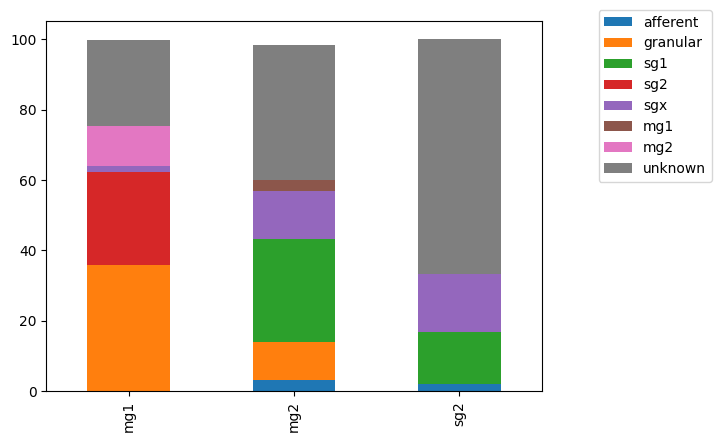

In [12]:
fig = plt.figure()
ax = plt.subplot(111)

pre_type = pd.DataFrame({'afferent': [0,3.1,2.1],
                         'granular': [35.8,10.8,0],
                         'sg1': [0,29.2,14.6],
                         'sg2': [26.4,0,0],
                         'sgx': [1.9,13.8,16.7],
                         'mg1': [0,3.1,0],
                         'mg2':[11.3,0,0],
                         'unknown':[24.5,38.5,66.7]},
                        index=['mg1', 'mg2', 'sg2'])
 
 
pre_type.plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05));

# # Add Title and Labels
# plt.title('Intermediate Students Pass %')
# plt.xlabel('Year')
# plt.ylabel('Percentage Ranges')

In [13]:
pre_type = pre_type.melt(ignore_index = False).reset_index()

Text(0, 0.5, 'Percent pre-synaptic cells')

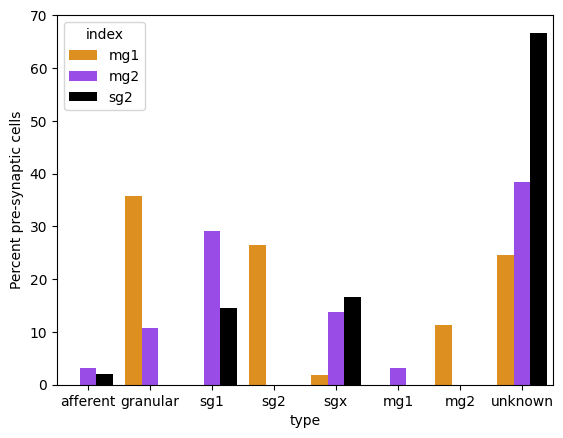

In [14]:
colors = ["#fd9400", "#9934ff","000000"] #color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff'}
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.barplot(data=pre_type, x="variable", y="value", hue="index")
plt.xlabel('type')
plt.ylabel('Percent pre-synaptic cells')

# Channels

## DisInhibition

In [ ]:
# cell_colors = {
#     'mg2' : '#0000ff',
#     'lf' : '#ff0000',
#     'mg1' : '#0000ff',
#     'lg' : '#ff0000',
#     'sgx' : '#0000ff',
#     'sg2' : '#0000ff',
#     'sg1' : '#0000ff',
#     'grc' : '#0000ff',
#     'aff' : '#ff0000',    
# }


In [16]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell = ecrest(settings_dict,launch_viewer=False)

base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [173]:
# nodes = ['214581797',
#          # '299249397',
#         '135497190',
#         # '134492570',
#         #'302714728',
#         #'308471538',
#         '305051491',
#         '228321391',
#         '56569586']

nodes = ['134492570',
         '386392158',
         '389812730',
        '403522169',
        '313068329',
        '668081112']

cell_colors = {
    '134492570' : '#9400D3', 
    '386392158' : '#0000ff',
    '389812730' : '#00FF00',
    '403522169' : '#ffdd00',
    '313068329' : '#ffdd00',#'#ffbf00',#'#FF7F00',
    '668081112' : '#ff0000',    
}

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [160]:
viewer = get_viewer(backgnd_color='white')

create_em_layer(viewer)

In [20]:
cells_to_add = ['61319896']#['484864533','483689146','476864694']

In [21]:

for i,x in enumerate(cells_to_add):# = nodes[0]
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    
    lname = cell.get_ctype('manual') + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(3)
    print(lname)

    
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = syn_colors[cell.get_ctype('manual')]#'#808080'#gray
        # for bs in cell.cell_data['base_segments']['axon']:
        #     s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]

aff_4_61319896


In [167]:
point_type = 'post-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ffffff'#'#ff00ff'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



In [ ]:
point_type = 'pre-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#ffffff'#'#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



## Inhibition

In [115]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child


filename = 'cell_graph_306242528__2023-07-03 09.54.17.json'
cell = ecrest(settings_dict,filepath= Path(settings_dict['save_dir']) / filename, launch_viewer=False)

base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [140]:
nodes = [#'387539479',
         #'389845032',
        '128770984',
        '213501262',
        '228366816',
        '56569586']

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [141]:
viewer = get_viewer(backgnd_color='white')

create_em_layer(viewer)

In [142]:
# cell_colors = {
#     'mg2' : '#0000ff',
#     'lf' : '#ff0000',
#     'mg1' : '#0000ff',
#     'lg' : '#ff0000',
#     'sg2' : '#0000ff',
#     'sg1' : '#0000ff',
#     'grc' : '#0000ff',
#     'aff' : '#ff0000',    
# }
cell_colors = {
    '213501262' : '#0000ff', 
    '128770984' : '#9400D3',
    # '305051491' : '#00FF00',
    '228366816' : '#ffdd00',#'#ffbf00',#'#FF7F00',
    '56569586' : '#ff0000',    
}

for i,x in enumerate(nodes):# = nodes[0]
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    sleep(3)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = cell_colors[x]#'#808080'#'#d2b48c' # blue
        # for bs in cell.cell_data['base_segments']['axon']:
        #     s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]

lg_4_128770984
mg1_5_213501262
grc_6_228366816
aff_7_56569586


In [143]:
point_type = 'post-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00ff00'#'#ff00ff'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



In [144]:
point_type = 'pre-synaptic'

syn_plot = set()
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_to_find = set([point[3] for point in cell.cell_data['end_points'][point_type]])
    
    for n_ in nodes:
        syn_plot=syn_plot.union(syn_to_find.intersection(base_segments[n_]))



syn_all = []
for n in nodes:
    cell = ecrest(settings_dict,filepath= nodefiles[n], launch_viewer=False)
    syn_all.extend([point for point in cell.cell_data['end_points'][point_type] if point[3] in syn_plot])


with viewer.txn(overwrite=True) as s:
    s.layers[point_type] = neuroglancer.AnnotationLayer()
    s.layers[point_type].annotationColor = '#00ff00'#'#00eeee'

with viewer.txn(overwrite=True) as s:
    for pos, point in enumerate(syn_all):
        point_array = array([int(point[x]/vx_sizes[x]) for x in range(3)])
        point_id = f'{point_type}_{pos}'
        pa = neuroglancer.PointAnnotation(id=point_id, point = point_array)
        s.layers[point_type].annotations.append(pa)   



# Cell Types Examples

In [61]:
cell_colors = {
    'mg2' : '#ff0000',
    'mg1' : '#0000ff',
    'lg' : '#ff0000',
    'lf' : '#0000ff',
    'sgx' : '#b3b3b3',
    'sg2' : '#ff9900',
    'sg1' : '#00ccff',
    'grc' : '#000000',
    'aff' : '#b3b3b3',    
}

structure_colors = {'unknown': '#d2b48c',
                    'multiple': '#9c661f',
                    'axon': '#008000',
                    'basal dendrite': '#cd4b00',
                    'apical dendrite': '#ff8000'
                   } 

In [58]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell = ecrest(settings_dict, launch_viewer=False)
base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [83]:
# nodes = [
#     '216004541',
#     '229531331',
#     '310793592',
#     '141117281',
#     '313285240',
#     '216977942', 
#     '219161561', 
#     '305051491', 
#     '306242528',
#     '389812730', 
#     '392042360', 
#     '45120720', 
#     '565013265',
#     '305020954',
#     '47366615',
#     '302668963',
#     '50786130',
#     '473723476',
#     '299530386',
#     '386117124',
#     '52008345',
#     '475920954',
#     '214581797',
#     '301787806',
#     '393325331']
nodes = ['306461085',
        '477962738']
nodes = ['394470350']
nodes = ['127672247', '130781211', '216004541', '216952227', '218095913',
       '220275752', '221326165', '300829569', '302714728', '306461085',
       '308471538', '309693374', '309743149', '386409916', '386488569',
       '393482133', '473491444', '476677382', '476801247', '477962738',
       '480081746', '480469318', '50786130', '648567066']
nodes = ['214581797']


cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [71]:
# cell_type 

In [63]:
viewer = get_viewer(backgnd_color='white')

create_em_layer(viewer)

In [84]:

for i,x in cell_type.items():# = nodes[0]
    lname = x + '_' + i 
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    sleep(3)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for dtype,seglist in cell.cell_data['base_segments'].items():
            for bs in seglist:
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = structure_colors[dtype]
        # for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
        #     s.layers[lname].segments.add(int(bs))
        #     s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]#'#808080'#gray
        # # for bs in cell.cell_data['base_segments']['axon']:
        # #     s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]

mg2_214581797


# Development

In [183]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir']) #/ 'todo_pre-synaptic/basal-dendrite_mg2'

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child



cell = ecrest(settings_dict,launch_viewer=False)

base_segments = cell.get_base_segments_dict(Path(settings_dict['save_dir']))

In [185]:
nodes = ['304031639',
         '303953883',
         '306242528',
         '305051491',
         '387539479',
         '389845032',
        '213501262',
        '308471538',
         '302714728',
         '214581797',
        '228321391',
        '228366816',
        '389812730',
        '403522169',
        '313068329',
        '299496636',
        '668081112']

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [178]:
viewer = get_viewer(backgnd_color='white')

create_em_layer(viewer)

In [186]:
# cell_colors = {
#     'mg2' : '#0000ff',
#     'lf' : '#ff0000',
#     'mg1' : '#0000ff',
#     'lg' : '#ff0000',
#     'sgx' : '#0000ff',
#     'sg2' : '#0000ff',
#     'sg1' : '#0000ff',
#     'grc' : '#0000ff',
#     'aff' : '#ff0000',    
# }
cell_colors = {
    'mg2' : '#0000ff',
    'lf' : '#ff0000',
    'mg1' : '#0000ff',
    'lg' : '#ff0000',
    'sgx' : '#0000ff',
    'sg2' : '#0000ff',
    'sg1' : '#0000ff',
    'grc' : '#0000ff',
    'aff' : '#ff0000',    
}


for i,x in enumerate(['668081112']):# = nodes[0]
    lname = cell_type[x] + '_' + str(i+4) + '_' + x
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    sleep(3)
    print(lname)

    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    sleep(2)
    with viewer.txn(overwrite=True) as s:
        for bs in set([str(a) for b in cell.cell_data['base_segments'].values() for a in b]):
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = '#000000'#'#808080'#'#d2b48c' # blue
        for bs in cell.cell_data['base_segments']['axon']:
            s.layers[lname].segment_colors[int(bs)] = cell_colors[cell_type[x]]

aff_4_668081112


# Volume subsample reconstruction

### segments from an NG json into an existing CREST

In [508]:
neuroglancer_path = '/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/volume-subsample-all'
filename = 'base_segs_revised.json'
neuroglancer_path = Path(neuroglancer_path) / filename

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)

In [509]:
segmentation_layer = next((item for item in neuroglancer_data['layers'] if item["source"] == 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930'), None)
base_segment_list_ng = set(segmentation_layer['segments'])



In [510]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']))

In [511]:
topop=set()
in_volume=[]
for k,v in base_segments.items():
    if base_segment_list_ng & v != set():
        # print(f'use reconstruction {k}')
        in_volume.append(k)
        topop = topop.union(base_segment_list_ng & v)

in_volume = np.unique(in_volume)

In [512]:
len(topop)

399

In [513]:
base_segment_list_ng = base_segment_list_ng.difference(topop)

In [514]:
todo_dict = {}
for seedseg in list(base_segment_list_ng):
    cell = ecrest(settings_dict,segment_id = seedseg,launch_viewer=False)
    todo_dict[seedseg] = set(cell.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1
    

In [515]:
len(todo_dict)

0

In [372]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [373]:
len(topop)

0

In [326]:
for segid in topop:
    todo_dict.pop(segid)
    

In [374]:
len(todo_dict)

1

In [ ]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'volume-subsample-all/in_progress')
    



### VIsualize cells in subvolume


In [522]:
nodefiles = get_cell_filepaths(dirpath)

In [523]:
len(in_volume)

179

In [524]:
color_structure = {'axon':'#008000','basal dendrite':'#cd4b00','apical dendrite':'#ff8000','unknown':'#d2b48c','multiple':'#9c661f','dendrite':'#ffff00'}
segs_in_volume = {}
for c_id in in_volume: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[c_id], launch_viewer=False)
    segs_in_volume[c_id]={}
    segs_in_volume[c_id]['seg_dict'] = cell.cell_data['base_segments'] #[a for b in cell.cell_data['base_segments'].values() for a in b]
    segs_in_volume[c_id]['type']=cell.get_ctype('manual')
    
    soma_diam = []
    soma_loc=[]
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        if len(soma_anno)==4:
            xpts = [p[0] for p in soma_anno]
            ypts = [p[1] for p in soma_anno]
            zpts = [p[2] for p in soma_anno]
            soma_diam = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])/1000
            soma_loc = (np.mean([np.max(xpts),np.min(xpts)])/1000,np.mean(ypts)/1000,np.mean([np.max(zpts),np.min(zpts)])/1000)
            
        if len(soma_anno)!=4:
            soma_diam = np.NaN
            soma_loc = np.NaN
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam = np.NaN
        soma_loc = np.NaN
        
    segs_in_volume[c_id]['soma_diam']=soma_diam
    segs_in_volume[c_id]['soma_loc'] = soma_loc

In [525]:
df_in_volume = pd.DataFrame([(i,c_id['type'],c_id['soma_loc'],c_id['soma_diam']) for i,c_id in segs_in_volume.items()],columns =['cid','type','soma_loc','soma_diam'])

In [526]:
df_in_volume[['x', 'y', 'z']] = df_in_volume['soma_loc'].apply(lambda loc: pd.Series(loc))
df_in_volume.drop(columns=['soma_loc'], inplace=True)

In [527]:
df_in_volume[df_in_volume['soma_diam'].isin([np.NaN])]['cid'].values

array([], dtype=object)

In [528]:
df_in_volume=df_in_volume[df_in_volume['type']!='aff']

In [529]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#ccccff',
    'uk':'#000000',
    'fov':'#000000',
    'focal types':'#33cc33',
    'glia':'#ffffff'
}

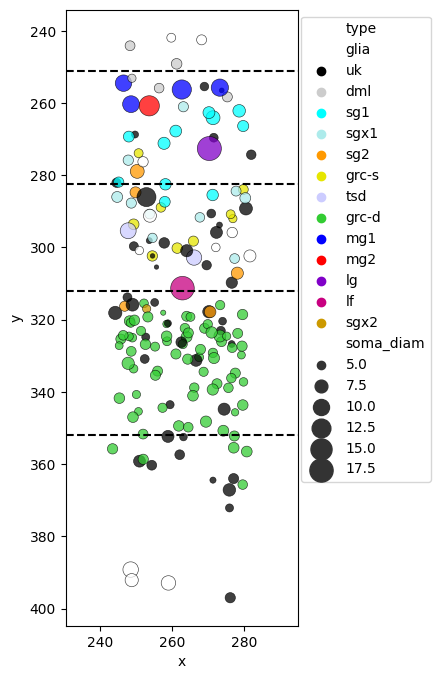

In [530]:
hfig,ax = plt.subplots(1,figsize=(3,8))
sns.scatterplot(data=df_in_volume,x='x',y='y',hue='type',size='soma_diam',sizes=(10, 300),
                alpha = 0.75,palette=syn_colors,edgecolor='black')
for y_ in [22000*16/1000, 19500*16/1000, 17650*16/1000, 15700*16/1000]:
    ax.axhline(y=y_,color = 'black',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1))
ax.invert_yaxis()

plt.axis('equal');
# ax.set_xlim(240,285)


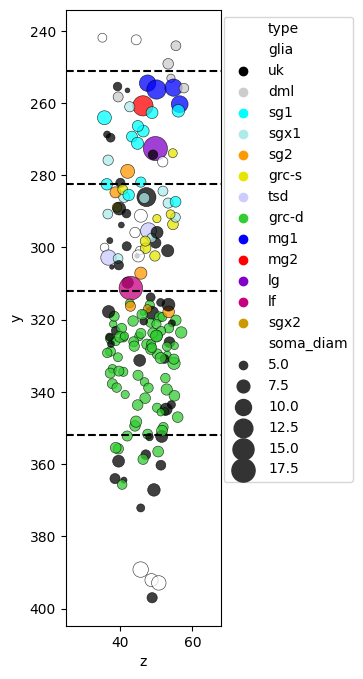

In [531]:
hfig,ax = plt.subplots(1,figsize=(2,8))
sns.scatterplot(data=df_in_volume,x='z',y='y',hue='type',size='soma_diam',sizes=(10, 300),
                alpha = 0.75,palette=syn_colors,edgecolor='black')
for y_ in [22000*16/1000, 19500*16/1000, 17650*16/1000, 15700*16/1000]:
    ax.axhline(y=y_,color = 'black',linestyle='--')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.9, 1))
ax.invert_yaxis()
plt.axis('equal');
# ax.set_xlim(35,65)

In [534]:
df_in_volume.groupby(['type']).count().loc[order_pre,['cid']]#/179*100

,cid
type,
grc-d,73
grc-s,9
sgx1,10
sgx2,1
sg1,11
sg2,5
mg1,4
mg2,1
lg,1


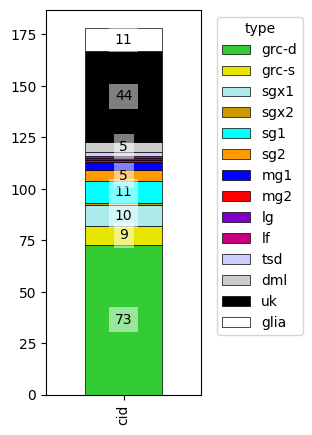

In [536]:
order_pre = ['grc-d','grc-s','sgx1','sgx2','sg1','sg2','mg1','mg2','lg','lf','tsd','dml','uk','glia']

ax = df_in_volume.groupby(['type']).count().loc[order_pre,['cid']].T.plot.bar(stacked=True,color = syn_colors,figsize=(2,5),edgecolor='black',linewidth=0.5)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.7, 1))

In [537]:
df_in_volume#

,cid,type,soma_diam,x,y,z
0,211241128,glia,5.2990,259.789625,241.933648,35.047808
1,213563250,uk,5.1560,268.970031,255.447184,39.254152
2,213577795,dml,5.8605,275.319344,258.320016,39.418621
3,214707822,sg1,8.3680,271.352000,264.084000,35.610000
4,215805462,uk,4.4995,249.758328,268.736367,36.358374
...,...,...,...,...,...,...
173,395567735,uk,7.5845,249.048797,315.855750,53.345964
174,396697514,grc-d,4.8430,245.369516,327.196695,55.005211
175,396728194,grc-d,5.3665,255.309383,327.463070,52.923463
176,396759154,grc-d,6.6625,270.971094,323.540813,56.872745


In [538]:
df_in_volume.groupby(['type']).describe().loc[order_pre,['soma_diam']]

soma_diam                                                               \
          count       mean       std      min       25%       50%        75%   
type                                                                           
grc-d      73.0   5.747466  0.561498   3.8960   5.40850   5.84050   6.110000   
grc-s       9.0   5.717000  0.435607   5.0055   5.32500   5.79750   6.065000   
sgx1       10.0   5.909500  0.270168   5.5535   5.72575   5.88325   6.014875   
sgx2        1.0   5.012500       NaN   5.0125   5.01250   5.01250   5.012500   
sg1        11.0   6.843500  0.641107   6.0025   6.42500   6.71300   7.034500   
sg2         5.0   6.918800  0.915212   5.9130   6.43250   6.78400   7.115500   
mg1         4.0  11.349625  1.192521  10.4280  10.66950  10.94275  11.622875   
mg2         1.0  14.083000       NaN  14.0830  14.08300  14.08300  14.083000   
lg          1.0  18.611000       NaN  18.6110  18.61100  18.61100  18.611000   
lf          1.0  18.001500       NaN  18.0015  18.00150  18.00150  18.001500   
tsd         2.0   9.697500  0.341533   9.4560   9.57675   9.69750   9.818250   
dml         5.0   5.700900  0.436124   5.0040   5.67450   5.77050   5.860500   
uk         44.0   5.800523  1.593184   3.6955   4.83250   5.41150   6.955500   
glia       11.0   6.762091  1.522866   5.0990   5.57225   6.07700   7.738000   

                
           max  
type            
grc-d   7.2460  
grc-s   6.2735  
sgx1    6.3700  
sgx2    5.0125  
sg1     8.3680  
sg2     8.3490  
mg1    13.0850  
mg2    14.0830  
lg     18.6110  
lf     18.0015  
tsd     9.9390  
dml     6.1950  
uk     12.8315  
glia    9.5695

<AxesSubplot:xlabel='type', ylabel='soma_diam'>

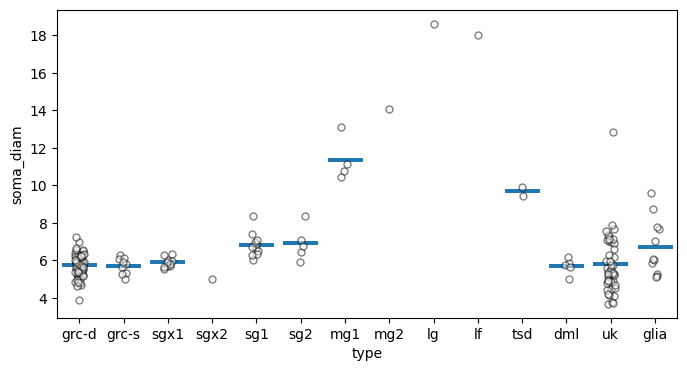

In [539]:
hfig,ax = plt.subplots(1,figsize=(8,4))
sns.stripplot(df_in_volume,x='type',y='soma_diam',order = order_pre,facecolor = 'white',edgecolor='black',linewidth=1,ax=ax,alpha=0.5)
sns.pointplot(df_in_volume,x='type',y='soma_diam',order = order_pre, join=False, errorbar=('ci', 0), capsize=.7, scale=0,ax=ax)

In [542]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)

In [547]:
# Define the dimensions of the annotation box
x_start = 15300 #15316
x_end = 17500 #17527
y_start = 15000
y_end = 25000
z_start = 1250
z_end = 1850

lname_ = 'bounding_box'

with viewer.txn(overwrite=True) as s:
    s.layers[lname_] = neuroglancer.AnnotationLayer()
    s.layers[lname_].annotationColor = '#000000'

    
    point_array = point #array([int(point[x]/vx_sizes[x]) for x in range(3)])
    point_id = f'{lname_}_1'
    pa = neuroglancer.AxisAlignedBoundingBoxAnnotation(id=point_id, 
                                      point_a = (x_start, y_start, z_start),point_b=(x_end, y_end, z_end))
    s.layers[lname_].annotations.append(pa)   
            


In [544]:
neuroglancer_path = '/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/volume-subsample-all'
filename = 'base_segs_revised.json'
neuroglancer_path = Path(neuroglancer_path) / filename

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)

segmentation_layer = next((item for item in neuroglancer_data['layers'] if item["source"] == 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930'), None)
base_segment_list_ng = set(segmentation_layer['segments'])



In [545]:
# each cell to a different tab    
lname = 'marked somas'
create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
with viewer.txn(overwrite=True) as s:
    for bs in base_segment_list_ng:
        s.layers[lname].segments.add(int(bs))
        s.layers[lname].segment_colors[int(bs)] = '#0000ff'
# sleep(2)

In [456]:
df_in_volume[df_in_volume['type']=='grc-s']

,cid,type,soma_diam,x,y,z
6,218157341,grc-s,5.7975,279.740156,283.961242,40.674688
7,219256490,grc-s,5.6295,256.933070,288.912617,39.102664
48,301682826,grc-s,5.3250,250.755109,273.898594,54.546414
58,305116146,grc-s,12.3145,249.370281,293.739078,48.549435
62,305176846,grc-s,5.0055,276.853344,292.021578,50.143171
66,306274968,grc-s,6.0650,254.551109,302.357453,49.595054
68,306289985,grc-s,6.1505,261.452539,300.188836,47.026571
69,306290102,grc-s,5.9190,265.923719,298.251008,46.931153
160,391049801,grc-s,5.2875,276.234812,290.813648,53.931326


In [454]:
# each cell to a different tab    
for i,c_id in segs_in_volume.items():
    if i in df_in_volume[df_in_volume['type']=='grc-s']['cid'].values:
        # print(c_id['type'])
        # break
        ctype = c_id['type']
        lname = i + '_' + ctype
        create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
        with viewer.txn(overwrite=True) as s:
            for dtype,keys in c_id['seg_dict'].items(): #segs_to_add[c_id]:
                for bs in keys: 
                    s.layers[lname].segments.add(int(bs))
                    try:
                        s.layers[lname].segment_colors[int(bs)] = color_structure[dtype] #syn_colors[ctype]#'#996633' # blue
                    except: 
                        s.layers[lname].segment_colors[int(bs)] = '#000000'
        sleep(2)